In [28]:
imagename = '4YIO'
#imagename = 'FBAP'
imagename = 'PI17'

# https://www.interasia.cc/content/c_service/cargo_tracking.aspx?SiteID=1

# Load Image (Palette)

In [29]:
from PIL import Image, ImageFilter, ImageEnhance
from IPython.display import display
import pytesseract as tess
import os
from collections import Counter

ims = []
dirname = os.path.join(os.getcwd(), imagename)
for filename in os.listdir(dirname) :
    fullname = os.path.join(dirname, filename)
    #print(fullname)
    im = Image.open(fullname)
    display(im)
    ims.append(im)

# Convert to RGB

In [30]:
ims_rgb = []
for im in ims :
    im_rgb = im.convert("RGB")
    #display(im_rgb)
    ims_rgb.append(im_rgb)

# pixelwise median image

In [31]:
def median_image ( ims_rgb ) :
    from statistics import median
    
    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(1,im_processed.size[0]-1) :
        for y in range(1,im_processed.size[1]-1) :
            
            rs = []
            gs = []
            bs = []
            for im in ims_rgb :
                rgb = im.load()[x,y]
                rs.append(rgb[0])
                gs.append(rgb[1])
                bs.append(rgb[2])
            
            r = int(median(rs))
            g = int(median(gs))
            b = int(median(bs))
        
            pix_processed[x,y] = ( r, g, b )
    
    return im_processed

# pixelwise statistics image

In [32]:
def statistics_image ( ims_rgb ) :
    from statistics import median
    
    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(1,im_processed.size[0]-1) :
        for y in range(1,im_processed.size[1]-1) :
            
            rs = []
            gs = []
            bs = []
            for im in ims_rgb :
                rgb = im.load()[x,y]
                rs.append(rgb[0])
                gs.append(rgb[1])
                bs.append(rgb[2])
            
            r = int(Counter(rs).most_common(1)[0][0])
            g = int(Counter(gs).most_common(1)[0][0])
            b = int(Counter(bs).most_common(1)[0][0])
        
            pix_processed[x,y] = ( r, g, b )
    
    return im_processed

# image-wise 9-median, stack-wise median

In [33]:
def median_image_single ( ims_rgb, stencil ) :
    from statistics import median
    
    def pattern ( pix, x, y ) :
        def indexed ( pix, x, y, idx ) :
            return pix[x,y][idx]
        r = []
        g = []
        b = []
        for dx in range(-stencil,stencil) :
            for dy in range(-stencil,stencil) :
                r.append( pix[x+dx,y+dy][0] )
                g.append( pix[x+dx,y+dy][1] )
                b.append( pix[x+dx,y+dy][2] )
        return (median( r ), median(g), median(b) )
    
    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(stencil,ims[0].size[0]-stencil) :
        for y in range(stencil,ims[0].size[1]-stencil) :
            
            rs = []
            gs = []
            bs = []
            white = False
            for im in ims_rgb :
                rgb = pattern(im.load(),x,y)
                rs.append(rgb[0])
                gs.append(rgb[1])
                bs.append(rgb[2])
                white |= im.load()[x,y] == (255,255,255)
            
            if white :
                r = g = b = 255
            else :                
                r = int(median(rs))
                g = int(median(gs))
                b = int(median(bs))
      
            pix_processed[x,y] = ( r, g, b )
    
    return im_processed

# image&stack-wise 9xN-median

In [34]:
def median_image_stack ( ims_rgb, stencil ) :
    from statistics import median
    
    def pattern ( pix, x, y ) :
        def indexed ( pix, x, y, idx ) :
            return pix[x,y][idx]
        r = []
        g = []
        b = []
        for dx in range(-stencil,stencil) :
            for dy in range(-stencil,stencil) :
                r.append( pix[x+dx,y+dy][0] )
                g.append( pix[x+dx,y+dy][1] )
                b.append( pix[x+dx,y+dy][2] )
        return [r, g, b]
    
    oversize = 5
    im_processed = Image.new("RGB", (ims[0].size[0] + oversize,ims[0].size[1] + oversize), (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(stencil,ims[0].size[0]-stencil) :
        for y in range(stencil,ims[0].size[1]-stencil) :
            
            rs = []
            gs = []
            bs = []
            white = False
            for im in ims_rgb :
                rgb = pattern(im.load(),x,y)
                rs.extend(rgb[0])
                gs.extend(rgb[1])
                bs.extend(rgb[2])                
                white |= im.load()[x,y] == (255,255,255)         
                
            if white :
                r = g = b = 255
            else :
                r = int(median(rs))
                g = int(median(gs))
                b = int(median(bs))
      
            pix_processed[x,y] = ( r, g, b )
    
    return im_processed

# whiten stack

In [35]:
def whiten_stack ( ims_rgb_orig ) :

    ims_rgb = []
    for im in ims_rgb_orig :
        ims_rgb.append( im.copy() )

    size = ims_rgb[0].size
        
    for x in range(0,size[0]) :
        for y in range(0,size[1]) :
            
            white = False
            for im in ims_rgb :
                white |= im.load()[x,y] == (255,255,255)         
                
            if white :
                for im in ims_rgb :
                    im.load()[x,y] = (255,255,255)         
    
    return ims_rgb

In [36]:
ims_rgb_whiten = whiten_stack( ims_rgb )
for im in ims_rgb_whiten :
    display(im)
#ims_rgb = ims_rgb_whiten

# grey filter

In [37]:
def grey_filter( im, lightness, colorness ) :

    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(1,im_processed.size[0]) :
        for y in range(1,im_processed.size[1]) :
         
            rgb = im.load()[x,y]
            r = rgb[0]
            g = rgb[1]
            b = rgb[2]
            
            # light color
            if (r+g+b)/3 > lightness :
                r = g = b = 255
            # shade of grey
            if max(r,g,b)-min(r,g,b) < colorness :
                r = g = b = 255             
                
            pix_processed[x,y] = ( r, g, b )
            
    return im_processed

In [38]:
def grey_filter_hsv( im, minsaturation, mindarkness ) :

    im_processed = Image.new("RGB", im.size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    im_hsv = im.convert('HSV')
    pix_hsv = im_hsv.load()
    
    for x in range(1,im_processed.size[0]) :
        for y in range(1,im_processed.size[1]) :
         
            rgb = im.load()[x,y]
            r = rgb[0]
            g = rgb[1]
            b = rgb[2]
            
            saturation = pix_hsv[x,y][1]
            darkness = 255 - pix_hsv[x,y][2]

            # not enough saturation and not dark enough?
            if saturation < minsaturation & darkness < mindarkness :
                r = g = b = 255
                
            pix_processed[x,y] = ( r, g, b )
            
    return im_processed

# unskew

In [39]:
def unskew( img, shear=-0.3, crop=10 ) :
    return img.copy().transform(img.size, Image.AFFINE, (1, shear, 0, 0, 1, 0)).crop((crop,0,img.size[0],img.size[1]))

In [40]:
display( ims_rgb[0] )
display( unskew(ims_rgb[0]))

# tesseract call

In [41]:
def image_2_text( im ):
    
    def call_tesseract( im, psm ) :
        text = tess.image_to_string(im, config='--psm ' + str(psm)).strip() # , lang='eng'
        #print(text)
        return text
    
    recognized = []
    recognized.append(call_tesseract(im,6))
    recognized.append(call_tesseract(im,7))
    recognized.append(call_tesseract(im,8))
    recognized.append(call_tesseract(im,13))
    return Counter(recognized)

# compare image processors

Counter({'PH7-': 2, 'PH': 2})


Counter({'pH]': 4})


Counter({'P17': 2, 'Pit].': 2})


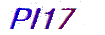

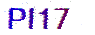

Counter({'P17': 2, 'PH7': 2})


In [42]:
im_processed = median_image( ims_rgb )
display(im_processed)
im_processed = unskew( im_processed )
display(im_processed)
print(image_2_text( im_processed ))

im_processed = statistics_image( ims_rgb )
display(im_processed)
im_processed = unskew( im_processed )
display(im_processed)
print(image_2_text( im_processed ))

im_processed = median_image_single( ims_rgb , 1 )
display(im_processed)
im_processed = unskew( im_processed )
display(im_processed)
print(image_2_text( im_processed ))

im_processed = median_image_stack( ims_rgb , 1 )
display(im_processed)
im_processed = unskew( im_processed )
display(im_processed)
print(image_2_text( im_processed ))

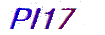

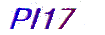

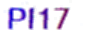

Counter({'PI17': 2, 'PIH7': 2})


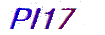

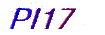

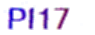

Counter({'PI17': 2, 'PIH7': 2})


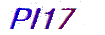

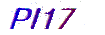

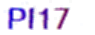

Counter({'PI17': 2, 'PIH7': 2})


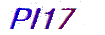

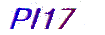

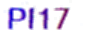

Counter({'PI17': 2, 'PIH7': 2})

Totals: Counter({'PI17': 8, 'PIH7': 8})


Counter({'PI17': 8, 'PIH7': 8})

In [43]:
def solve ( ims_rgb ) :
    recognized = Counter()

    for minsaturation in (30,50,70,90) :
        im_processed = median_image_stack( ims_rgb , 1 )
        #display(im_processed.resize((200,60), resample=Image.NEAREST))
        display(im_processed)

        im_processed = grey_filter_hsv ( im_processed, minsaturation, 100 )
        #display(im_processed.resize((200,60), resample=Image.NEAREST))
        display(im_processed)

        im_processed = unskew( im_processed )
        enhancer = ImageEnhance.Contrast(im_processed)
        im_processed = enhancer.enhance(1).filter(ImageFilter.BoxBlur(1))
        display(im_processed)
        
        text = image_2_text( im_processed )
        recognized += text
        print(text)

    print("\nTotals: " + str(recognized))
    return recognized

solve( ims_rgb )

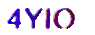

Counter({'4YIO': 2, '4YIO-': 2})


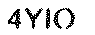

Counter({'4ViO': 2, '4YIO |': 2})


In [26]:
#im_processed = remove_dots(im_processed, 150)
#display(im_processed)

im_processed = im_processed.filter(ImageFilter.MedianFilter(3))
display(im_processed)

print(image_2_text( im_processed ))

im_tess = Image.new("RGB", im_processed.size, (255, 255, 255))
im_tess.paste(im_processed)
#im_tess = im_tess.filter(ImageFilter.MedianFilter(1))
im_tess = im_tess.convert('1')
display(im_tess)

print(image_2_text( im_tess ))

# FastAPI implementation

In [18]:
# Basic import of FastAPI and function to start running the API with Uvicorn

import uvicorn
from fastapi import FastAPI

app = FastAPI()

def run():
    uvicorn.run(app)

In [19]:
# Code in this cell is just for (re)starting the API on a Process, and other compatibility stuff with Jupyter cells.
# Just ignore it!

from multiprocessing import Process
from wait4it import wait_for

_api_process = None

def start_api():
    """Stop the API if running; Start the API; Wait until API (port) is available (reachable)"""
    global _api_process
    if _api_process:
        _api_process.terminate()
        _api_process.join()
    
    _api_process = Process(target=run, daemon=True)
    _api_process.start()
    wait_for(port=8000)

def delete_route(method: str, path: str):
    """Delete the given route from the API. This must be called on cells that re-define a route"""
    [app.routes.remove(route) for route in app.routes if method in route.methods and route.path == path]

INFO:     Started server process [3675]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


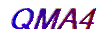

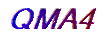

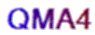

Counter({'YMA4': 2, 'QMA4': 2})


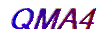

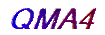

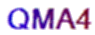

Counter({'QMA4': 4})


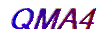

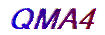

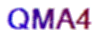

Counter({'YMA4': 2, 'QMA4': 2})


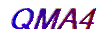

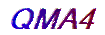

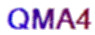

Counter({'YMA4': 2, 'QMA4': 2})

Totals: Counter({'QMA4': 10, 'YMA4': 6})
INFO:     127.0.0.1:40606 - "POST /captcha HTTP/1.1" 200 OK


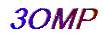

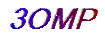

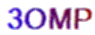

Counter({'OMP': 2, '30MP': 2})


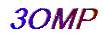

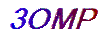

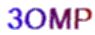

Counter({'OMP': 2, '30MP': 2})


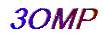

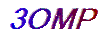

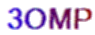

Counter({'OMP': 2, '30MP': 2})


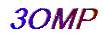

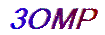

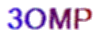

Counter({'OMP': 2, '30MP': 2})

Totals: Counter({'OMP': 8, '30MP': 8})
INFO:     127.0.0.1:41986 - "POST /captcha HTTP/1.1" 200 OK


In [44]:
from pydantic import BaseModel
from typing import List
from typing import Optional
from PIL import Image
import io
import base64

class Captcha(BaseModel):
    url: str
    imagedata: List[str]

@app.post("/captcha")
def solve_captcha(captcha: Captcha):
    #print(base64.b64decode(captcha.imagedata))
    images = []
    for s in captcha.imagedata :
        im = Image.open(io.BytesIO(base64.b64decode(s))).convert("RGB")
        images.append(im)
        display(im)
    result = solve( images )
    return dict(result)

start_api()